In [133]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Parameters
sequence_length = 10
num_samples = 300  
target_size = (244, 244)
batch_size = 1
num_classes = 4

In [134]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2]
)

train_generator = datagen.flow_from_directory(
    'Data/AugmentedAlzheimerDataset',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    'Data/AugmentedAlzheimerDataset',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [135]:
train_generator = datagen.flow_from_directory(
    'Data/AugmentedAlzheimerDataset',
    target_size=(244, 244),
    batch_size=1,
    class_mode='categorical',
    subset='training'  
)

validation_generator = datagen.flow_from_directory(
    'Data/AugmentedAlzheimerDataset',
    target_size=(244, 244),
    batch_size=1,
    class_mode='categorical',
    subset='validation'  
)

Found 27188 images belonging to 4 classes.
Found 6796 images belonging to 4 classes.


In [136]:
base_cnn = VGG16(weights='imagenet', include_top=False, input_shape=(*target_size, 3))
cnn_model = Sequential([
    base_cnn,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3)
])

In [137]:
train_sequences = np.zeros((num_samples, sequence_length, 256))
train_labels = []
for i in range(num_samples):
    sequence_labels = []
    for j in range(sequence_length):
        img, label = next(train_generator)
        feature_vector = cnn_model.predict(img)
        train_sequences[i, j, :] = feature_vector.flatten()
    train_labels.append(label[0])

train_labels = np.array(train_labels)

val_sequences = np.zeros((num_samples // 5, sequence_length, 256))  
val_labels = []
for i in range(num_samples // 5):
    sequence_labels = []
    for j in range(sequence_length):
        img, label = next(val_generator)
        feature_vector = cnn_model.predict(img)
        val_sequences[i, j, :] = feature_vector.flatten()
    val_labels.append(label[0])

val_labels = np.array(val_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/

In [138]:

model = Sequential([
    LSTM(100, activation='relu', return_sequences=True, input_shape=(sequence_length, 256)),
    Dropout(0.3),
    LSTM(50, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

In [139]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])


In [140]:
history = model.fit(
    train_sequences, train_labels,
    epochs=20,
    batch_size=16,
    validation_data=(val_sequences, val_labels),
    callbacks=[lr_scheduler]
)

Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2796 - loss: 1.3919 - val_accuracy: 0.3000 - val_loss: 1.3480 - learning_rate: 1.0000e-04
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2317 - loss: 1.3925 - val_accuracy: 0.3833 - val_loss: 1.3511 - learning_rate: 1.0000e-04
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2832 - loss: 1.3546 - val_accuracy: 0.3833 - val_loss: 1.3523 - learning_rate: 1.0000e-04
Epoch 4/20
13/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2715 - loss: 1.3770 
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2720 - loss: 1.3767 - val_accuracy: 0.3000 - val_loss: 1.3538 - learning_rate: 1.0000e-04
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3154 - loss: 1.3589 - val_accuracy: 0.3000 - val_loss: 1.3515 - learning_rate: 5.0000e-05
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2967 - loss: 1.

In [141]:
val_loss, val_accuracy = model.evaluate(val_sequences, val_labels)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.2f}")

model.save("lstm_bci_model.keras")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.3153 - loss: 1.3591  
Validation Loss: 1.3552
Validation Accuracy: 0.32


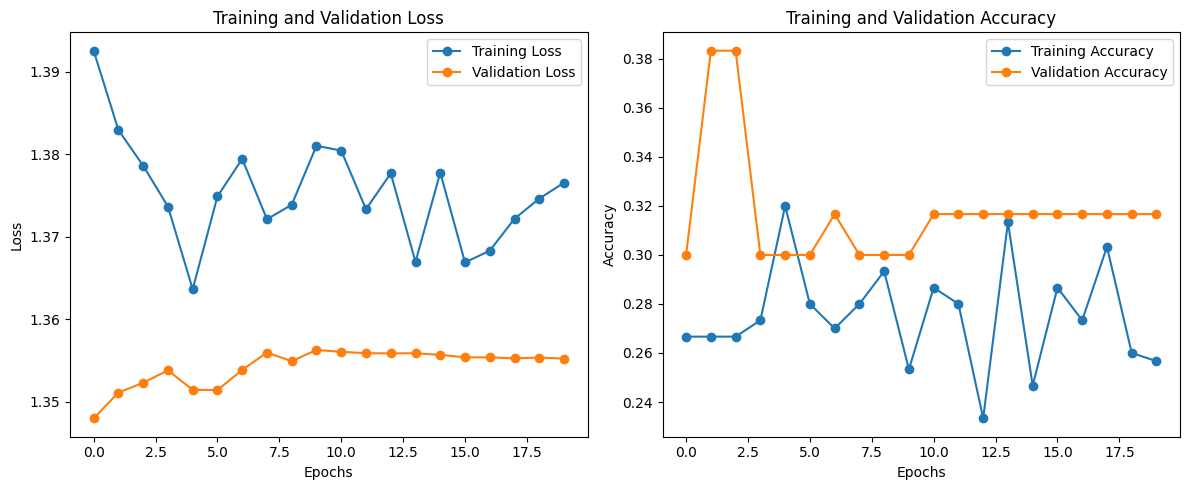

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss', marker='o')
plt.plot(val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy', marker='o')
plt.plot(val_acc, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

metrics_table = pd.DataFrame({
    'Epoch': list(range(1, len(train_loss) + 1)),
    'Train Loss': train_loss,
    'Validation Loss': val_loss,
    'Train Accuracy': train_acc,
    'Validation Accuracy': val_acc
})

print(metrics_table)

metrics_table.to_csv('training_metrics.csv', index=False)


    Epoch  Train Loss  Validation Loss  Train Accuracy  Validation Accuracy
0       1    1.392532         1.347998        0.266667             0.300000
1       2    1.382917         1.351122        0.266667             0.383333
2       3    1.378603         1.352306        0.266667             0.383333
3       4    1.373658         1.353814        0.273333             0.300000
4       5    1.363641         1.351454        0.320000             0.300000
5       6    1.374882         1.351428        0.280000             0.300000
6       7    1.379431         1.353866        0.270000             0.316667
7       8    1.372122         1.355970        0.280000             0.300000
8       9    1.373870         1.354927        0.293333             0.300000
9      10    1.381012         1.356283        0.253333             0.300000
10     11    1.380436         1.356052        0.286667             0.316667
11     12    1.373329         1.355893        0.280000             0.316667
12     13   

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


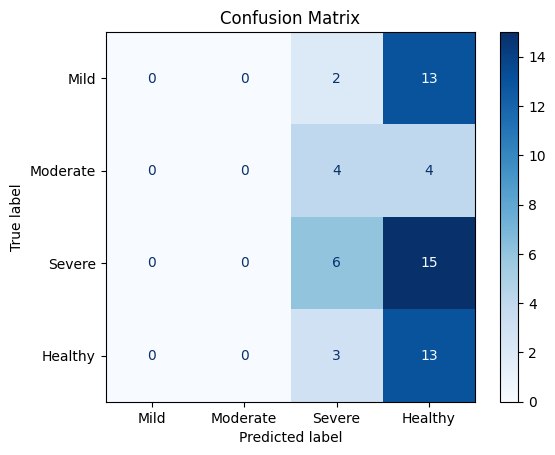

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

class_names = ['Mild', 'Moderate', 'Severe', 'Healthy']

val_predictions = model.predict(val_sequences)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = np.argmax(val_labels, axis=1)

conf_matrix = confusion_matrix(val_true_classes, val_pred_classes)

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(val_true_classes, val_pred_classes, target_names=class_names)
print(report)

with open('classification_report.txt', 'w') as f:
    f.write(report)


              precision    recall  f1-score   support

        Mild       0.00      0.00      0.00        15
    Moderate       0.00      0.00      0.00         8
      Severe       0.40      0.29      0.33        21
     Healthy       0.29      0.81      0.43        16

    accuracy                           0.32        60
   macro avg       0.17      0.27      0.19        60
weighted avg       0.22      0.32      0.23        60



c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
